# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [9]:
import gym
from gym.spaces import Box
import numpy as np

try:
    import cv2
except ImportError:
    cv2 = None

In [10]:
env = gym.make("CarRacing-v0")

/home/sebastian/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
state = env.reset()

Track generation: 1175..1473 -> 298-tiles track


In [12]:
import matplotlib.pyplot as plt

[]

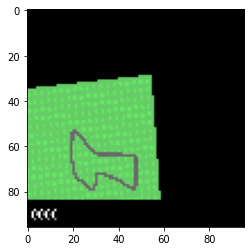

In [13]:
plt.imshow(state)
plt.plot()

In [14]:
state.shape

(96, 96, 3)

In [15]:
# bring observation in desired shape and scale observation between 0 and 1
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(state), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):
        obs = cv2.resize(obs, (self.screen_size, self.screen_size), interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64))
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64))
        return obs
        
        

In [16]:
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)

In [17]:
state = env.reset()

Track generation: 1148..1439 -> 291-tiles track


array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.22352941, 0.22352941, 0.22352941],
        [0.2784314 , 0

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

# V-Model

In [19]:
class VAE():
    def __init__(self, state_size, latent_size_N=32):
              
        self.encoder = Encoder(state_size, latent_size_N)
        self.decoder = Decoder(state_size, latent_size_N)
        
        
    def forward(self, image: torch.Tensor)-> torch.Tensor:
        
        assert image.shape == (3, 64, 64), "Input Image as wrong shape!"
        encoded = self.encoder(image)
        
        decoded = self.decoder(encoded)
        return decoded
    
    def encode_state(self, image: torch.Tensor)-> torch.Tensor:
        assert image.shape == (3, 64, 64), "Input Image as wrong shape!"
        encoded = self.encoder(image)
        return encoded
        
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        self.softplus = nn.Softplus() #use different activation?
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        print(x.shape)
        x = torch.relu(self.conv2(x))
        print(x.shape)
        x = torch.relu(self.conv3(x))
        print(x.shape)
        x = torch.relu(self.conv4(x))
        print(x.shape)
        
        mu = torch.tanh(self.output_mu(x.flatten(1)))
        sig = self.softplus(self.output_sig(x.flatten(1)))
        
        dist = Normal(mu, sig) # in the paper they had different sample methods this one and mu + sig *N(0,1)
        
        latent_vector_z = dist.sample()
            
        return latent_vector_z

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        print(x.shape)
        x = torch.relu(self.deconv2(x))
        print(x.shape)
        x = torch.relu(self.deconv3(x))
        print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        print(x.shape)
        return x

In [20]:
encoder = Encoder((64,64,3))
decoder = Decoder((64,64,3))

In [21]:
out = encoder(state.unsqueeze(0))

torch.Size([1, 32, 31, 31])
torch.Size([1, 64, 14, 14])
torch.Size([1, 128, 6, 6])
torch.Size([1, 256, 2, 2])


In [22]:
out.shape

torch.Size([1, 32])

In [23]:
decoder(out)

torch.Size([1, 128, 5, 5])
torch.Size([1, 64, 13, 13])
torch.Size([1, 32, 30, 30])
torch.Size([1, 3, 64, 64])


tensor([[[[0.4784, 0.4792, 0.4793,  ..., 0.4775, 0.4792, 0.4780],
          [0.4820, 0.4798, 0.4816,  ..., 0.4803, 0.4785, 0.4802],
          [0.4793, 0.4821, 0.4785,  ..., 0.4766, 0.4776, 0.4779],
          ...,
          [0.4793, 0.4816, 0.4796,  ..., 0.4800, 0.4800, 0.4799],
          [0.4791, 0.4783, 0.4776,  ..., 0.4781, 0.4798, 0.4792],
          [0.4792, 0.4814, 0.4798,  ..., 0.4797, 0.4796, 0.4791]],

         [[0.4911, 0.4923, 0.4918,  ..., 0.4901, 0.4912, 0.4905],
          [0.4930, 0.4914, 0.4923,  ..., 0.4928, 0.4923, 0.4932],
          [0.4897, 0.4924, 0.4915,  ..., 0.4905, 0.4914, 0.4907],
          ...,
          [0.4895, 0.4913, 0.4885,  ..., 0.4916, 0.4912, 0.4900],
          [0.4927, 0.4920, 0.4932,  ..., 0.4935, 0.4914, 0.4925],
          [0.4916, 0.4919, 0.4906,  ..., 0.4929, 0.4925, 0.4914]],

         [[0.5172, 0.5177, 0.5187,  ..., 0.5194, 0.5182, 0.5189],
          [0.5191, 0.5208, 0.5204,  ..., 0.5191, 0.5186, 0.5198],
          [0.5167, 0.5149, 0.5169,  ..., 0

# M-Model

In [80]:
class MModel(nn.Module):
    def __init__(self, action_size, latent_size=32, hidden_size=256, batch_size=64, n_gaussians=5, rnn_type="LSTM"):
        super(MModel, self).__init__()
        
        self.input_shape = action_size+latent_size
        self.action_size = action_size
        self.latent_size = latent_size
        self.n_gaussians = n_gaussians
        self.batch_size = batch_size
        
        if rnn_type == "LSTM":
            self.rnn_layer = nn.LSTM(self.input_shape, hidden_size, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn_layer = nn.GRU(self.input_shape, hidden_size, batch_first=True)
            
        self.pi_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.mu_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        self.sig_layer = nn.Linear(hidden_size, n_gaussians*latent_size)
        
        
    def forward(self, latent_vector: torch.Tensor, action:torch.Tensor, hidden_state=None)-> torch.Tensor:
        """ Simple forward pass with the RNN """
        
        assert latent_vector.shape == (latent_vector.shape[0], self.latent_size), "Latent vector has the wrong shape!"
        assert action.shape == (action.shape[0], self.action_size), "Action batch has the wrong shape!"
        
        input_tensor = torch.cat((latent_vector, action),dim=1).unsqueeze(1)
        assert input_tensor.shape == (action.shape[0], 1, self.input_shape), "input_tensor has wrong shape!"
        
        output, hidden_state = self.rnn_layer(input_tensor, hidden_state)
        
        (pi, mu, sigma) = self.get_gauss_coeffs(output)
        return (pi, mu, sigma), hidden_state
    
    
    def get_gauss_coeffs(self, y:torch.Tensor):
        
        rollout_length = y.size(1)
        
        pi = self.pi_layer(y)
        mu = self.mu_layer(y)
        sigma = self.sig_layer(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.latent_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
    
    def predict_next_z(self,latent_vector: torch.Tensor, action:torch.Tensor, tau: float, hidden_state=None)-> torch.Tensor:
        """ Predicts the next Latent Vector Z """
        values, hidden_state = self.forward(latent_vector, action, hidden_state)
        mu, sigma = values[1], values[2]
        
        dist = Normal(mu, sigma*tau)
        z_ = dist.sample().mean(2)
        print(z_.shape)
        
        prediction = [torch.normal(mu, sigma)[:, :, i, :] for i in range(self.n_gaussians)]
        return prediction, hidden_state
        
# M-Model loss calculation
def mdn_loss_fn(y, pi, mu, sigma):
    m = Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()


def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [81]:
m_model = MModel(action_size=4)

In [82]:
action = torch.ones((1,4))
z, hidden = m_model(out, action)

In [83]:
z_, h = m_model.predict_next_z(out, action, None)

torch.Size([1, 1, 32])


In [71]:
z_[4].shape

torch.Size([1, 1, 32])